In [9]:
import torch
import numpy as np

In [4]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
transform= transforms.ToTensor()

In [6]:
train_set= datasets.FashionMNIST(root='data', download = True, train = True, transform= transform)
test_set= datasets.FashionMNIST(root='data', download = True, train = False, transform= transform)

In [7]:
batch_size= 64
num_workers = 0
valid_size = 0.2

In [10]:
num_train= len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split= int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [11]:
train_sampler= SubsetRandomSampler(train_idx)
valid_sampler= SubsetRandomSampler(valid_idx)

In [32]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)


classes = ['0: T-shirt/top', '1: Trouser', '2: Pullover', '3: Dress', '4: Coat', 
               '5: Sandal', '6: Shirt', '7: Sneaker', '8: Bag', '9: Ankle boot']

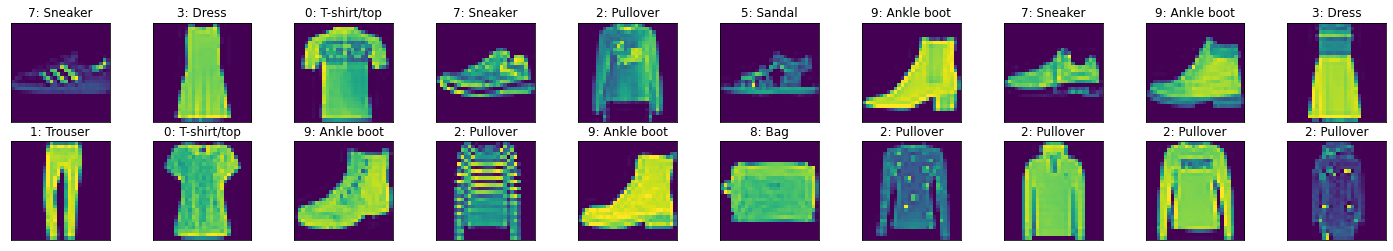

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline 

dataiter= iter(train_loader)
images, labels = dataiter.next()

images= images.numpy()
fig= plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[idx]))
    ax.set_title(classes[labels[idx]])

In [50]:
import torch.nn as nn



class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        
        self.conv1 = nn.Conv2d(1,32,3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,stride=1,padding=1)
        
        self.pool= nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(3136,128)
        self.fc2 = nn.Linear(128,10)
        
        self.dropout= nn.Dropout(0.5)
        
        
    def forward(self,x):
        x= self.pool(F.relu(self.conv1(x)))
        x= self.pool(F.relu(self.conv2(x)))
        
        
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        
        return x


In [51]:
model= Net()
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [52]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [54]:
n_epochs= 20
valid_loss_min= np.Inf


for epoch in range(n_epochs):
    train_loss=0.0
    valid_loss=0.0
    
    model.train()
    
    
    for data, target in train_loader:
        optimizer.zero_grad()
        output=model(data)
        loss=criterion(output,target)
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.item() * data.size(0)
        
    
    
    
    model.eval()
    for data,target in valid_loader:
        output=model(data)
        loss=criterion(output,target)
        
        valid_loss+= loss.item()* data.size(0)
        
        
        
    train_loss= train_loss/len(train_loader.sampler)
    valid_loss= valid_loss/len(valid_loader.sampler)
    
    
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.701656 	Validation Loss: 0.552191
Validation loss decreased (inf --> 0.552191).  Saving model ...
Epoch: 2 	Training Loss: 0.647513 	Validation Loss: 0.519615
Validation loss decreased (0.552191 --> 0.519615).  Saving model ...
Epoch: 3 	Training Loss: 0.606707 	Validation Loss: 0.498277
Validation loss decreased (0.519615 --> 0.498277).  Saving model ...
Epoch: 4 	Training Loss: 0.575272 	Validation Loss: 0.466941
Validation loss decreased (0.498277 --> 0.466941).  Saving model ...
Epoch: 5 	Training Loss: 0.549757 	Validation Loss: 0.445215
Validation loss decreased (0.466941 --> 0.445215).  Saving model ...
Epoch: 6 	Training Loss: 0.526868 	Validation Loss: 0.432868
Validation loss decreased (0.445215 --> 0.432868).  Saving model ...
Epoch: 7 	Training Loss: 0.508608 	Validation Loss: 0.409754
Validation loss decreased (0.432868 --> 0.409754).  Saving model ...
Epoch: 8 	Training Loss: 0.492684 	Validation Loss: 0.399927
Validation loss decreased (0.40975

In [55]:
model.load_state_dict(torch.load('model.pt'))


<All keys matched successfully>

In [57]:
test_loss= 0.0
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))


model.eval()

for data,target in test_loader:
    output= model(data)
    loss= criterion(output,target)
    test_loss+=loss.item() * data.size(0)
    
    _,pred=torch.max(output,1)
    
    correct=np.squeeze(pred.eq(target.data.view_as(pred)))
    
    
    for i in range(len(target)):
        label=target.data[i]
        
        class_correct[label]+=correct[i].item()
        class_total[label]+=1
        
        
test_loss= test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))


for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.350188

Test Accuracy of     0: 82% (828/1000)
Test Accuracy of     1: 96% (969/1000)
Test Accuracy of     2: 83% (832/1000)
Test Accuracy of     3: 91% (910/1000)
Test Accuracy of     4: 74% (742/1000)
Test Accuracy of     5: 97% (971/1000)
Test Accuracy of     6: 61% (612/1000)
Test Accuracy of     7: 94% (947/1000)
Test Accuracy of     8: 96% (968/1000)
Test Accuracy of     9: 94% (945/1000)

Test Accuracy (Overall): 87% (8724/10000)


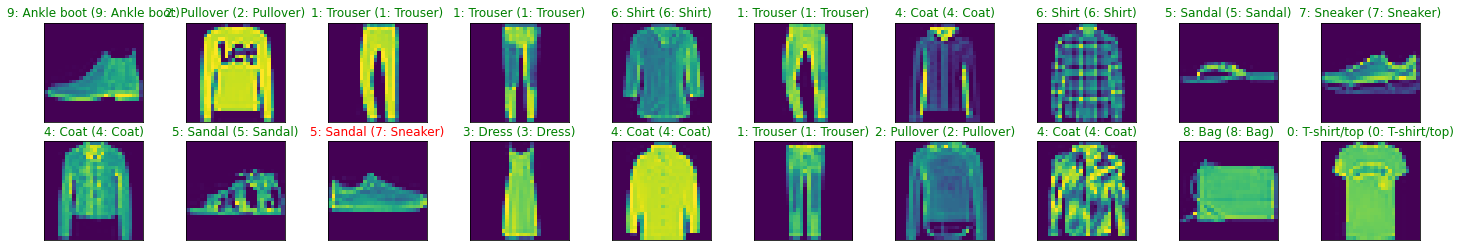

In [65]:
images,labels= next(iter(test_loader))
output= model(images)
_,pred= torch.max(output,1)

images=images.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax= fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[idx]))
    ax.set_title("{} ({})".format((classes[pred[idx]]), (classes[labels[idx]])),
    color=("green" if pred[idx]==labels[idx] else "red"))